# Rotten Tomatoes Reviews
### Realizado por: Carlos Lizarazo, Carlos Romero, Javier Santodomingo
---



## 1. Descripción del problema

El conjunto de datos proporcionado contiene reseñas de películas del sitio web Rotten Tomatoes. Cada reseña de texto está etiquetada como positiva o negativa, dependiendo de la opinión expresada por el crítico. Por tanto, el problema que se plantea es un problema de *clasificación supervisada, más específicamente de **análisis de sentimientos (sentiment analysis)*.

El objetivo principal es entrenar un modelo de aprendizaje automático que sea capaz de *predecir si una reseña es positiva o negativa* basándose únicamente en el contenido textual de la reseña. Esta es una tarea común en el área de procesamiento del lenguaje natural (NLP, por sus siglas en inglés), ya que ayuda a automatizar la comprensión de opiniones humanas escritas en lenguaje natural.

### Descripción de las variables del conjunto de datos

Con la documentación disponible en Kaggle trabajamos con el dataset *rt_reviews* [1] y el apoyo de otras documentaciones relacionadas, como *RT Reviews Classification with LSTM de Hariharan* [2]. Para este proyecto, el conjunto de datos incluye las siguientes columnas:

- Review: Texto de la reseña realizada por un crítico de cine o tambien un usuario. Es una variable de tipo texto.
- Freshness: Etiqueta que indica si la reseña es "fresh" or "rotten". Es una variable categórica que representa la clase que se debe predecir (variable objetivo o target).

Este conjunto de datos puede ser utilizado para explorar diferentes modelos de clasificación como regresión logística, árboles de decisión, random forest, redes neuronales, entre otros más, que se encuentran implementados en la libreria sklearn, se pueden ver estos métodos a detalle en la página oficial sklearn que contiene la documentación [3].

El dataset no contiene valores numéricos directamente analizables por modelos de machine learning, por lo que se requerirá aplicar técnicas de preprocesamiento, como la vectorización de texto usando TF-IDF, el cual para este proyecto nos apoyamos de su implementación de un articulo en la página oficial de builtin [4].

Primero, cargamos el dataset y mostramos una vista previa. Asegurandonos de que el archivo .csv esté en la misma carpeta del proyecto.

In [3]:
import pandas as pd

df = pd.read_csv('rt_reviews.csv', encoding='latin1')
df.head()

,Freshness,Review
0,fresh,"Manakamana doesn't answer any questions, yet ..."
1,fresh,Wilfully offensive and powered by a chest-thu...
2,rotten,It would be difficult to imagine material mor...
3,rotten,Despite the gusto its star brings to the role...
4,rotten,If there was a good idea at the core of this ...


Procedemos a ver la información del dataset relevante y verificar la distribución para la columna 'Freshness' y 'Review'.

In [ ]:
df.info()

df['Freshness'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480000 entries, 0 to 479999
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Freshness  480000 non-null  object
 1   Review     480000 non-null  object
dtypes: object(2)
memory usage: 7.3+ MB


,count
Freshness,
fresh,240000
rotten,240000


Se observa que el conjunto de datos tiene alrededor de 480 mil registros, con las dos etiquetas: "fresh" y "rotten", las cuales están en la columna llamada "Freshness" y la otra columna llamada Review que contiene la descripción de la reseña. El dataset está balanceado en cuanto a la cantidad de ejemplos por clase, sin embargo tomaremos una parte de nrows para trabajar el proyecto de la mejor forma.

In [5]:
df = pd.read_csv('rt_reviews.csv', encoding='latin1', nrows=15000)

Ahora bien, continuamos con la sección de descripción e inspeccion de datos.

## 2. Descripción e inspección de datos mediante gráficos

Primeramente, analizaremos cuántas palabras se repiten en este dataset especificamente en las reviews, para ello lo haremos con las 25 que más lo logran hacer mediante un gráfico de barras.

In [7]:
import re
import collections
import matplotlib.pyplot as plt
import seaborn as sns

reviews = ' '.join(df['Review'].dropna().astype(str))
words = re.findall(r'\b\w+\b', reviews.lower())
frequency = collections.Counter(words)
top_words = frequency.most_common(25)
words, freq = zip(*top_words)

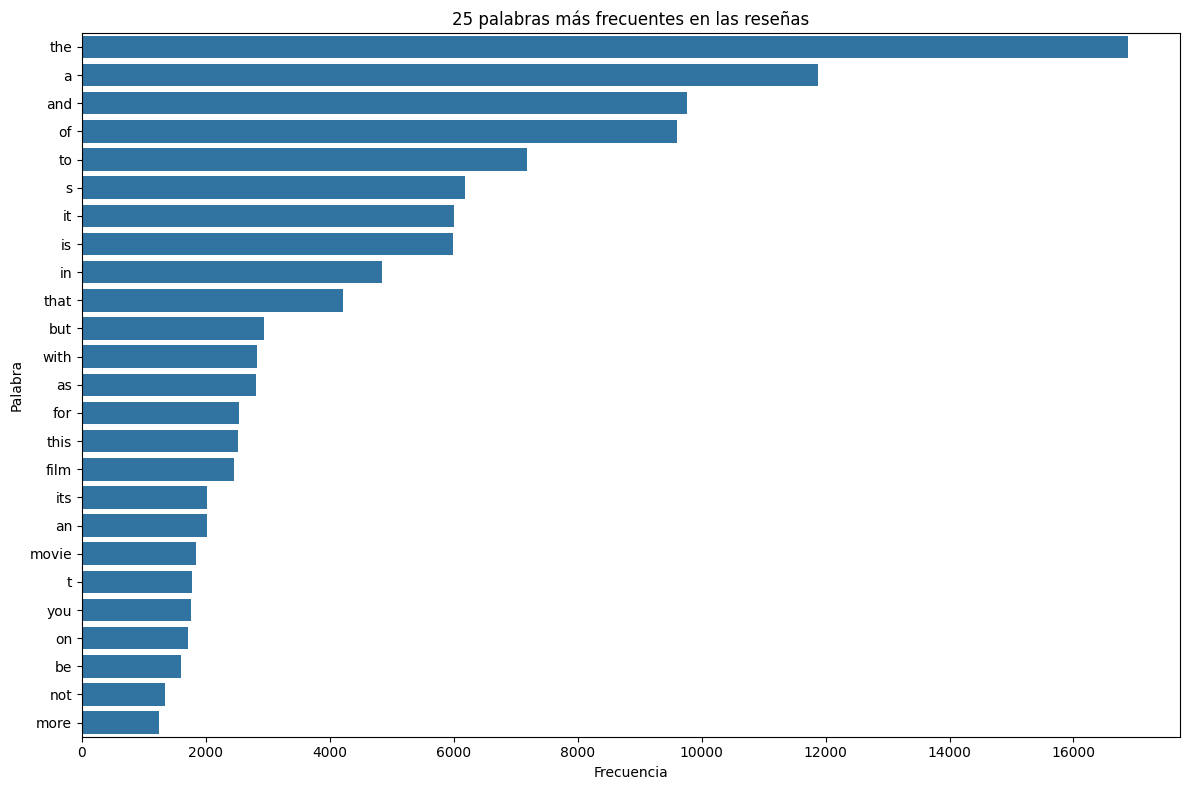

In [ ]:
df_top_words = pd.DataFrame({'Palabra': words, 'Frecuencia': freq})
plt.figure(figsize=(12, 8))

sns.barplot(x='Frecuencia', y='Palabra', data=df_top_words, orient='h')

plt.title('25 palabras más frecuentes en las reseñas')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.tight_layout()
plt.show()

Observamos que muchas de las palabras más comunes son "palabras vacías" (stopwords) como "the", "and", "a", "to", que son artículos, conjunciones y preposiciones. Estas palabras suelen tener poco valor semántico individualmente para determinar el sentimiento de una reseña, este análisis inicial sugiere la necesidad de preprocesar el texto, lo que podría incluir la eliminación de stopwords, para centrar el análisis en palabras que aporten más significado al sentimiento.

Por otra parte, haremos un gráfico circular (pie) para tener una idea visual de la distribución para las etiquetas freshness.

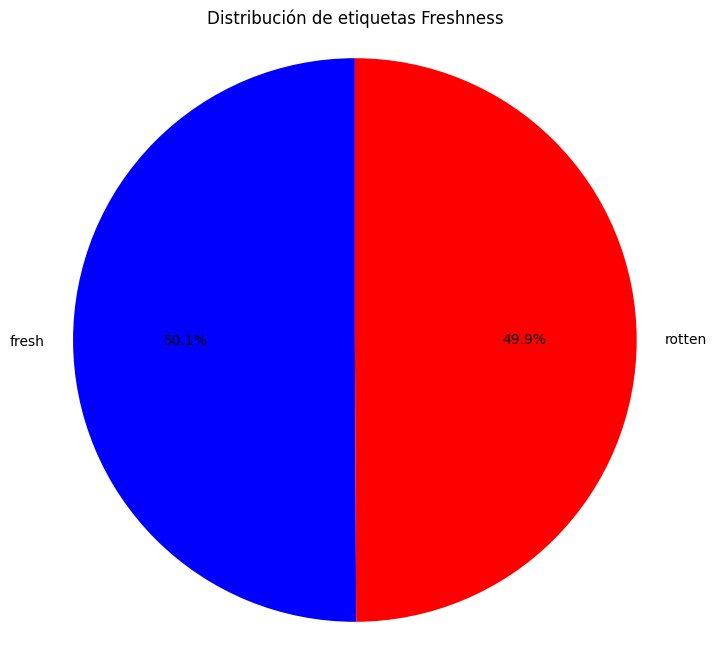

In [ ]:
freshness_counts = df['Freshness'].value_counts()

labels = freshness_counts.index
sizes = freshness_counts.values
colors = ['blue', 'red']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribución de etiquetas Freshness')
plt.axis('equal')
plt.show()

La gráfica ciruclar muestra la distribución de las etiquetas "Freshness", separando las reseñas en "fresh" (positivas) y "rotten" (negativas). Visualmente, se aprecia un porcentaje muy similar de reseñas para ambas categorías, lo que indica que el dataset se encuentra bien balanceado.

Este balance es favorable para el entrenamiento de modelos de clasificación, ya que evita problemas asociados al desbalance de clases y permite que los modelos aprendan de manera equitativa sobre las características que definen tanto una reseña positiva como una negativa.

Procedemos a realizar un histograma del conteo de simbolos y numeros que se encuentren en las reseñas.

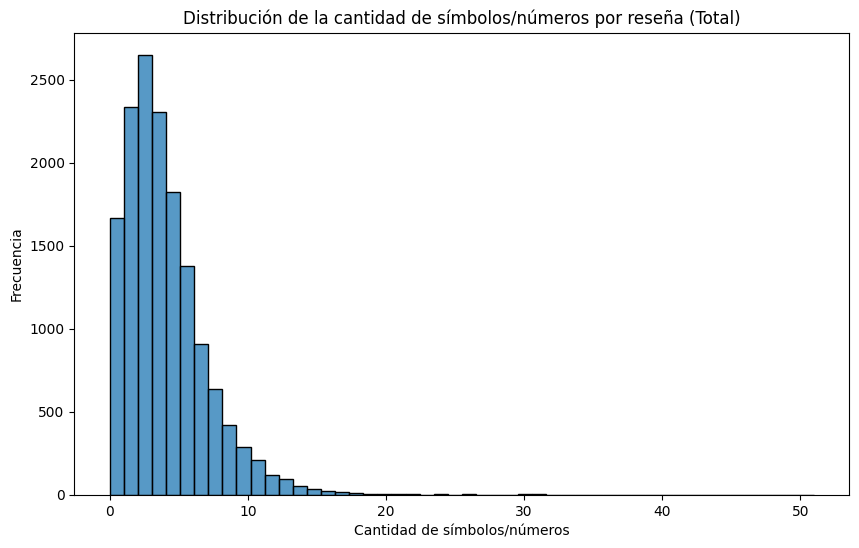

In [9]:
def count_symbols_and_numbers(text):
     if pd.isna(text):
         return 0
     symbols_and_numbers = re.findall(r'[^a-zA-Z\s]', str(text))
     return len(symbols_and_numbers)

df['symbols_numbers_count'] = df['Review'].apply(lambda x: count_symbols_and_numbers(x))

plt.figure(figsize=(10, 6))

sns.histplot(df['symbols_numbers_count'], bins=50, kde=False)

plt.title('Distribución de la cantidad de símbolos/números por reseña (Total)')
plt.xlabel('Cantidad de símbolos/números')
plt.ylabel('Frecuencia')
plt.show()

El histograma muestra una distribución marcadamente sesgada hacia la izquierda, con la mayoría de las reviews conteniendo pocos símbolos y números. La concentración en valores bajos indica que el texto es predominantemente alfabético. Sin embargo, la presencia de reviews con una mayor cantidad de símbolos y números, aunque menos frecuentes, sugiere que el conjunto de datos contiene cierto "ruido" en forma de caracteres no alfabéticos, por lo cual se ve necesario aplicar técnicas de limpieza de datos, como la eliminación de símbolos y puntuación, para preparar adecuadamente el texto antes de realizar análisis de sentimiento o entrenar modelos de clasificación.

Ahora bien, procedemos con la sección de estrategias para la preparación de datos.

## 3. Estrategias para la preparación de datos.

Para esta sección planeamos las siguientes estrategias a seguir en este orden, para poder realizar una buena preparación de datos sin ningún problema:

Primeramente, procedemos a convertir las palabras de las review a minúsculas.

In [11]:
df['Review'] = df['Review'].astype(str).str.lower()

Verificamos la salida para comprobar de que están en minúsculas

In [12]:
df['Review'].head()

,Review
0,"manakamana doesn't answer any questions, yet ..."
1,wilfully offensive and powered by a chest-thu...
2,it would be difficult to imagine material mor...
3,despite the gusto its star brings to the role...
4,if there was a good idea at the core of this ...


Recordando lo que hicimos en la sección 2, procedemos a eliminar las palabras de las reviews que no son importantes, las stopwords, puesto que no influirán en los modelos.

In [13]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
  return " ".join([word for word in str(text).split() if word not in stop_words])

df['Review'] = df['Review'].apply(lambda x: remove_stopwords(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df['Review'].head()

,Review
0,"manakamana answer questions, yet makes point: ..."
1,wilfully offensive powered chest-thumping mach...
2,would difficult imagine material wrong spade l...
3,"despite gusto star brings role, hard ride shot..."
4,"good idea core film, buried unsightly pile fla..."


Usamos la libreria nltk para apoyarnos de la stopwords en inglés,  que crea un conjunto llamado stop_words con estas palabras, luego, definimos una función remove_stopwords que toma un texto como entrada, lo divide en palabras y reconstruye el texto omitiendo aquellas palabras que se encuentran en el conjunto stop_words. Finalmente, esta función aplica a cada entrada de la columna 'Review' del DataFrame df, actualizando la columna con el texto preprocesado, procedemos a verificar.

Ahora bien, procedemos a eliminar los signos de puntuación y símbolos que se encuentren en las reviews.

In [14]:
import re

def remove_symbols_and_punctuation(text):
  return re.sub(r'[^a-zA-Z0-9\s]', '', text)

df['Review'] = df['Review'].apply(lambda x: remove_symbols_and_punctuation(x))

In [ ]:
df['Review'].head()

,Review
0,manakamana answer questions yet makes point ne...
1,wilfully offensive powered chestthumping machi...
2,would difficult imagine material wrong spade l...
3,despite gusto star brings role hard ride shotg...
4,good idea core film buried unsightly pile flat...


Como se puede observar previamente, definimos una función para remover signos de puntuación y simbolos en la columna de reviews, y verificamos que ha sido satisfactorio.

Ahora, buscaremos que las palabras logren estar en infinitivo sin ningún tipo de conjugación, nos apoyaremos en la libreria de nltk usando WordNetLemmatizer.

In [15]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer

def get_wordnet_pos(tag):
    """Mapea el tag de POS de NLTK a los tags de WordNet."""
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


Ahora definimos una función para normalizarlas mediante lematización con POS.

In [16]:
def normalize_words_lemmatization_with_pos(text, lemmatizer):
    result = []
    words_with_pos = nltk.pos_tag(text.split())
    for word, tag in words_with_pos:
        pos = get_wordnet_pos(tag)
        result.append(lemmatizer.lemmatize(word, pos=pos))
    return ' '.join(result)

wordnet_lemmatizer = WordNetLemmatizer()

df['Review'] = df['Review'].apply(lambda x: normalize_words_lemmatization_with_pos(x, wordnet_lemmatizer))

In [ ]:
df['Review'].head()

,Review
0,manakamana answer question yet make point nepa...
1,wilfully offensive power chestthumping machism...
2,would difficult imagine material wrong spade l...
3,despite gusto star brings role hard ride shotg...
4,good idea core film bury unsightly pile flatul...


Se aplicó un proceso de lematización utilizando la biblioteca NLTK y el recurso WordNet, cada reseña fue procesada palabra por palabra; primero se determinó la parte del habla (POS) de cada término mediante nltk.pos_tag, luego se mapeó este tag al formato compatible con WordNet utilizando una función auxiliar. Finalmente, el WordNetLemmatizer fue aplicado a cada palabra, pasándole el tag POS correspondiente, para reducirla a su forma base léxicamente correcta, resultando en un texto preprocesado donde las variaciones de palabras se han unificado para facilitar el análisis posterior.

Ahora bien, verificamos nuevamente haciendo la gráfica de barras para las 25 palabras más usadas luego de todo el proceso de preparación de datos.

In [17]:
reviews = ' '.join(df['Review'].dropna().astype(str))
words = re.findall(r'\b\w+\b', reviews.lower())
frequency = collections.Counter(words)
top_words = frequency.most_common(25)
words, freq = zip(*top_words)

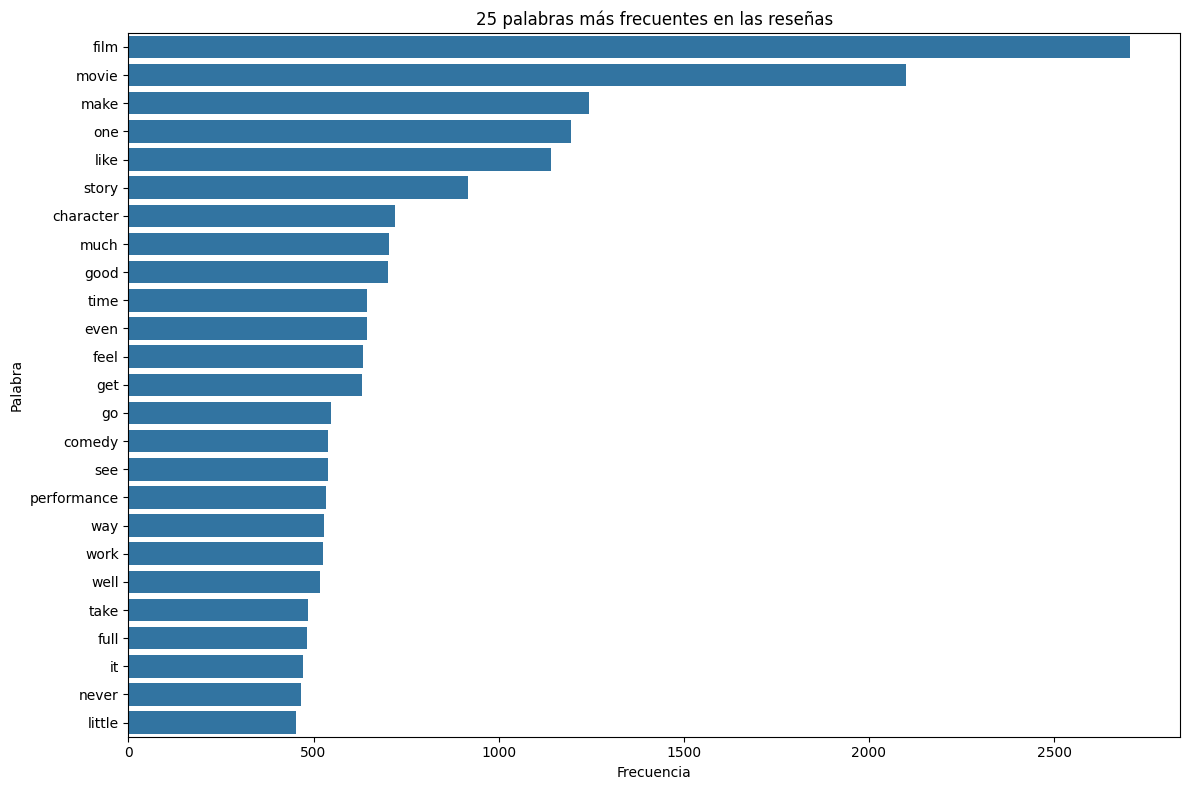

In [ ]:
df_top_words = pd.DataFrame({'Palabra': words, 'Frecuencia': freq})
plt.figure(figsize=(12, 8))

sns.barplot(x='Frecuencia', y='Palabra', data=df_top_words, orient='h')

plt.title('25 palabras más frecuentes en las reseñas')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.tight_layout()
plt.show()

Analizamos tambien la gráfica correspondiente de símbolos y números, que es un histograma

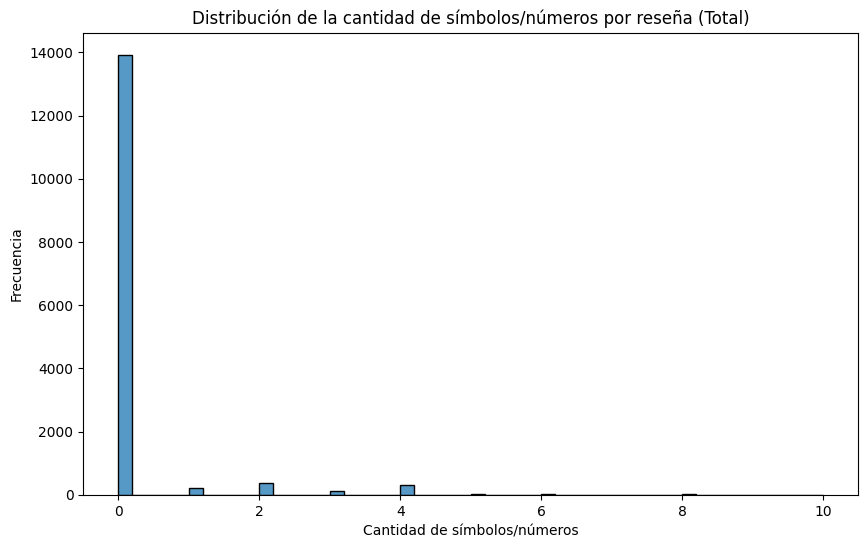

In [18]:
def count_symbols_and_numbers(text):
     if pd.isna(text):
         return 0
     symbols_and_numbers = re.findall(r'[^a-zA-Z\s]', str(text))
     return len(symbols_and_numbers)

df['symbols_numbers_count'] = df['Review'].apply(lambda x: count_symbols_and_numbers(x))

plt.figure(figsize=(10, 6))

sns.histplot(df['symbols_numbers_count'], bins=50, kde=False)

plt.title('Distribución de la cantidad de símbolos/números por reseña (Total)')
plt.xlabel('Cantidad de símbolos/números')
plt.ylabel('Frecuencia')
plt.show()

 Después del preprocesamiento (conversión a minúsculas, eliminación de stopwords, signos de puntuación, simbolos y lematización), muestra una clara mejora en comparación con las primeras gráfica, revelando términos que son potencialmente más significativos para el análisis de sentimiento, como "film", "movie", "like", "time", "good", "story". Ahora el análisis se centra en palabras que tienen más probabilidades de contribuir a la identificación del sentimiento positivo o negativo en las reviews.

Procedemos ahora a la parte de vectorización de texto de las reviews.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(analyzer = 'word')
tfidfvectorizer = tfidf.fit_transform(df['Review'])
tfidf_tokens = tfidf.get_feature_names_out()
df_tfidfvect = pd.DataFrame(data = tfidfvectorizer.toarray(),columns = tfidf_tokens)
datasetDef = pd.concat([df['Freshness'], df_tfidfvect], axis=1)
datasetDef['Freshness'] = datasetDef['Freshness'].map({'fresh': 1, 'rotten': 0})


Se utiliza TfidfVectorizer de la biblioteca sklearn para transformar el texto preprocesado de las reseñas de películas (df['Review']) en una representación numérica. TfidfVectorizer calcula la frecuencia de los términos (TF) y la frecuencia inversa de los documentos (IDF) para asignar un peso a cada palabra en relación con su importancia en una reseña individual y en todo el conjunto de datos. Se aplica esta vectorización al texto de las reseñas, se extrae los nombres de las palabras (tokens) resultantes, crea un DataFrame (df_tfidfvect) con estos valores numéricos y finalmente concatena este DataFrame con la columna original de "Freshness" (df['Freshness']) para crear un conjunto de datos final (datasetDef) listo para ser utilizado en los modelos de clasificación que trabajaremos.Tambien aplicamos el Ordinal Encoding a la columna freshness, el método map de las Series de Pandas permite reemplazar cada valor de la Serie por otro valor basándose en un diccionario o una función. Aquí, mapeamos 'fresh' a 1 y 'rotten' a 0.

In [ ]:
datasetDef.head(10)

,Freshness,007,10,100,1000,10000,1001,100year,101,1010,...,zucker,zuckerberg,zuckers,zupan,zvyaginstsev,zvyagintsev,zweig,zwick,zwicks,zwickwe
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Una vez culminado esta parte del preprocesamiento del texto, seguimos con la selección de características mediante RFC.

### Seleccion de características

Ahora bien, procederemos a realizar la seleccion de características para freshness, que es nuestro target a trabajar.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

y_data = datasetDef['Freshness']
x_data = datasetDef.drop(['Freshness'], axis=1)
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100, random_state=42))
sel.fit(x_data, y_data)

selected_features_mask = sel.get_support()

selected_features = x_data.columns[selected_features_mask]

x_data_selected = x_data[selected_features]

In [ ]:
print(f"Original number of features: {x_data.shape[1]}")
print(f"Number of selected features: {x_data_selected.shape[1]}")
print("Selected features:")
print(selected_features)

Original number of features: 24272
Number of selected features: 3416
Selected features:
Index(['10', '100', '12', '13', '15', '1960s', '1970s', '20', '2010', '2016',
       ...
       'york', 'you', 'young', 'youngster', 'youth', 'yule', 'zemeckis',
       'zhivago', 'zombie', 'zone'],
      dtype='object', length=3416)


De las 24272 características del dataset, el modelo de selección ha recomendado que se usen 3416, esto lo vemos reflejado previamente en el lenght. Ahora, procedemos a quitar las caracteristicas que no fueron seleccionadas.

In [ ]:
columns_to_drop = list(set(x_data.columns) - set(selected_features))
x_data.drop(columns = columns_to_drop, inplace = True)
x_data.reset_index(drop=True, inplace=True)

Verificamos los resultados correspondientes.

In [ ]:
x_data.head(10)

,10,100,12,13,15,1960s,1970s,20,2010,2016,...,york,you,young,youngster,youth,yule,zemeckis,zhivago,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Basándonos en los resultados de la selección de características utilizando el modelo RandomForestClassifier, se aprecia un subconjunto significativo de las palabras presentes en las reseñas que son consideradas relevantes por el modelo para predecir el sentimiento (fresh/rotten). La reducción de características ayudará a disminuir la complejidad computacional, potencialmente mitigar el sobreajuste y enfocar el modelo a realizar la tarea de clasificación debidamente, para ello seguimos con la sección de implementación y entrenamiento de modelos.

## 4. Implementación y entrenamiento de los modelos



Primeramente haremos una separación de los datos de entrenamiento, con los datos de prueba.

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3)

Ahora bien procederemos a irlos entrenando por cada modelo usando GridSearchCV, quien encontrará los mejores hiperparámetros basandose en el rendimiento de los datos de entrenamiento y luego evaluarlo en el conjunto de prueba.

### Regresión multivariada

#### Prueba 1

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix

parametros = {
    'C': [0.0001, 0.001, 0.01],
    'penalty': ['l2','l1'],
    'solver': ['liblinear', 'saga']
}

kf = KFold(n_splits=4, shuffle=True, random_state=4)

gridscv = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42),
                      parametros,
                      scoring='accuracy',
                      cv=kf,
                      refit=True
                     )

model_result = gridscv.fit(x_train, y_train)

#### Resultados

In [ ]:
print("Resultado training (Best Parameters):")
print(model_result.best_params_)
print("\n")
print('Accuracy (on Training Data):')
print(f"{(model_result.best_score_*100):.2f}%")
print("\n")

y_pred = model_result.predict(x_test)

print('Accuracy (on Test Data):')
print(f"{(model_result.score(x_test, y_test)*100):.2f}%")
print("\n")

print("Classification Report (on Test Data):")
print(classification_report(y_test, y_pred))
print("\n")

print("Confusion Matrix (on Test Data):")
print(confusion_matrix(y_test, y_pred))

Resultado training (Best Parameters):
{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


Accuracy (on Training Data):
71.18%


Accuracy (on Test Data):
72.76%


Classification Report (on Test Data):
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      2270
           1       0.72      0.73      0.73      2230

    accuracy                           0.73      4500
   macro avg       0.73      0.73      0.73      4500
weighted avg       0.73      0.73      0.73      4500



Confusion Matrix (on Test Data):
[[1656  614]
 [ 612 1618]]


#### Prueba 2

In [ ]:
parametros = {
    'C': [0.001, 0.01, 1, 2],
    'penalty': ['l2','l1'],
    'solver': ['liblinear', 'saga']
}

kf = KFold(n_splits=4, shuffle=True, random_state=4)

gridscv = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42),
                      parametros,
                      scoring='accuracy',
                      cv=kf,
                      refit=True
                     )

model_result = gridscv.fit(x_train, y_train)

#### Resultados

In [ ]:
print("Resultado training (Best Parameters):")
print(model_result.best_params_)
print("\n")
print('Accuracy (on Training Data):')
print(f"{(model_result.best_score_*100):.2f}%")
print("\n")

y_pred = model_result.predict(x_test)

print('Accuracy (on Test Data):')
print(f"{(model_result.score(x_test, y_test)*100):.2f}%")
print("\n")

print("Classification Report (on Test Data):")
print(classification_report(y_test, y_pred))
print("\n")

print("Confusion Matrix (on Test Data):")
print(confusion_matrix(y_test, y_pred))

Resultado training (Best Parameters):
{'C': 2, 'penalty': 'l2', 'solver': 'liblinear'}


Accuracy (on Training Data):
71.30%


Accuracy (on Test Data):
72.96%


Classification Report (on Test Data):
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      2270
           1       0.73      0.72      0.73      2230

    accuracy                           0.73      4500
   macro avg       0.73      0.73      0.73      4500
weighted avg       0.73      0.73      0.73      4500



Confusion Matrix (on Test Data):
[[1667  603]
 [ 614 1616]]


#### Prueba 3

In [ ]:
parametros = {
    'C': [2, 4, 6, 10],
    'penalty': ['l2','l1'],
    'solver': ['liblinear', 'saga']
}

kf = KFold(n_splits=4, shuffle=True, random_state=4)

gridscv = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42),
                      parametros,
                      scoring='accuracy',
                      cv=kf,
                      refit=True
                     )

model_result = gridscv.fit(x_train, y_train)

#### Resultados

In [ ]:
print("Resultado training (Best Parameters):")
print(model_result.best_params_)
print("\n")
print('Accuracy (on Training Data):')
print(f"{(model_result.best_score_*100):.2f}%")
print("\n")

y_pred = model_result.predict(x_test)

print('Accuracy (on Test Data):')
print(f"{(model_result.score(x_test, y_test)*100):.2f}%")
print("\n")

print("Classification Report (on Test Data):")
print(classification_report(y_test, y_pred))
print("\n")

print("Confusion Matrix (on Test Data):")
print(confusion_matrix(y_test, y_pred))

Resultado training (Best Parameters):
{'C': 2, 'penalty': 'l2', 'solver': 'liblinear'}


Accuracy (on Training Data):
71.30%


Accuracy (on Test Data):
72.96%


Classification Report (on Test Data):
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      2270
           1       0.73      0.72      0.73      2230

    accuracy                           0.73      4500
   macro avg       0.73      0.73      0.73      4500
weighted avg       0.73      0.73      0.73      4500



Confusion Matrix (on Test Data):
[[1667  603]
 [ 614 1616]]


La primera prueba exploró un amplio rango de valores para el parámetro de regularización C [0.0001, 0.001, 0.01], junto con las penalizaciones 'l2' y 'l1' y los solvers 'liblinear' y 'saga', con el objetivo de identificar la región general del espacio de parámetros que ofrecía el mejor desempeño inicial, resultando en {'C': 2, 'penalty': 'l2', 'solver': 'liblinear'}. Las pruebas subsiguientes (Prueba 2 con C: [0.001, 0.01, 1, 2], Prueba 3 con C: [2, 4, 6, 10], ambas manteniendo 'l2', 'l1', 'liblinear', 'saga') buscaron refinar esta búsqueda al centrar los valores de C en rangos más estrechos alrededor del óptimo identificado, con la expectativa de encontrar una combinación aún mejor; sin embargo, los resultados consistentes en las ultimas pruebas 2 y 3 y otras más, indican repetidamente {'C': 2, 'penalty': 'l2', 'solver': 'liblinear'} como los mejores parámetros y un accuracy similar, sugieren que el modelo de Regresión Logística, con las características y datos actuales, puede haber alcanzado un rendimiento estable dentro de las opciones exploradas para estos hiperparámetros.

### Árboles de decisión

#### Prueba 1

In [ ]:
from sklearn.tree import DecisionTreeClassifier

parametros = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

kf = KFold(n_splits=4, shuffle=True, random_state=4)

gridscv = GridSearchCV(DecisionTreeClassifier(), parametros, scoring='accuracy', cv=kf, n_jobs=-1, refit=True)

model_result = gridscv.fit(x_train, y_train)

#### Resultados

In [ ]:
print("Resultado training (Best Parameters):")
print(model_result.best_params_)
print("\n")
print('Accuracy (on Training Data):')
print(f"{(model_result.best_score_*100):.2f}%")
print("\n")

y_pred = model_result.predict(x_test)

print('Accuracy (on Test Data):')
print(f"{(model_result.score(x_test, y_test)*100):.2f}%")
print("\n")

print("Classification Report (on Test Data):")
print(classification_report(y_test, y_pred))
print("\n")

print("Confusion Matrix (on Test Data):")
print(confusion_matrix(y_test, y_pred))

Resultado training (Best Parameters):
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'best'}


Accuracy (on Training Data):
52.93%


Accuracy (on Test Data):
52.04%


Classification Report (on Test Data):
              precision    recall  f1-score   support

           0       0.51      0.97      0.67      2270
           1       0.67      0.06      0.11      2230

    accuracy                           0.52      4500
   macro avg       0.59      0.52      0.39      4500
weighted avg       0.59      0.52      0.40      4500



Confusion Matrix (on Test Data):
[[2202   68]
 [2090  140]]


#### Prueba 2

In [ ]:
parametros = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best'],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [20, 30, 50, None],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [2, 4, 8]
}

kf = KFold(n_splits=4, shuffle=True, random_state=4)

gridscv = GridSearchCV(DecisionTreeClassifier(), parametros, scoring='accuracy', cv=kf, n_jobs=-1, refit=True)

model_result = gridscv.fit(x_train, y_train)

#### Resultados

In [ ]:
print("Resultado training (Best Parameters):")
print(model_result.best_params_)
print("\n")
print('Accuracy (on Training Data):')
print(f"{(model_result.best_score_*100):.2f}%")
print("\n")

y_pred = model_result.predict(x_test)

print('Accuracy (on Test Data):')
print(f"{(model_result.score(x_test, y_test)*100):.2f}%")
print("\n")

print("Classification Report (on Test Data):")
print(classification_report(y_test, y_pred))
print("\n")

print("Confusion Matrix (on Test Data):")
print(confusion_matrix(y_test, y_pred))

Resultado training (Best Parameters):
{'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 30, 'splitter': 'best'}


Accuracy (on Training Data):
62.54%


Accuracy (on Test Data):
63.09%


Classification Report (on Test Data):
              precision    recall  f1-score   support

           0       0.63      0.66      0.64      2270
           1       0.64      0.60      0.62      2230

    accuracy                           0.63      4500
   macro avg       0.63      0.63      0.63      4500
weighted avg       0.63      0.63      0.63      4500



Confusion Matrix (on Test Data):
[[1505  765]
 [ 896 1334]]


#### Prueba 3

In [ ]:
parametros = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best'],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [15, 20, 30, None],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 4, 6]
}

kf = KFold(n_splits=4, shuffle=True, random_state=4)

gridscv = GridSearchCV(DecisionTreeClassifier(), parametros, scoring='accuracy', cv=kf, n_jobs=-1, refit=True)

model_result = gridscv.fit(x_train, y_train)

#### Resultados

In [ ]:
print("Resultado training (Best Parameters):")
print(model_result.best_params_)
print("\n")
print('Accuracy (on Training Data):')
print(f"{(model_result.best_score_*100):.2f}%")
print("\n")

y_pred = model_result.predict(x_test)

print('Accuracy (on Test Data):')
print(f"{(model_result.score(x_test, y_test)*100):.2f}%")
print("\n")

print("Classification Report (on Test Data):")
print(classification_report(y_test, y_pred))
print("\n")

print("Confusion Matrix (on Test Data):")
print(confusion_matrix(y_test, y_pred))

Resultado training (Best Parameters):
{'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'splitter': 'best'}


Accuracy (on Training Data):
62.12%


Accuracy (on Test Data):
63.47%


Classification Report (on Test Data):
              precision    recall  f1-score   support

           0       0.64      0.64      0.64      2270
           1       0.63      0.63      0.63      2230

    accuracy                           0.63      4500
   macro avg       0.63      0.63      0.63      4500
weighted avg       0.63      0.63      0.63      4500



Confusion Matrix (on Test Data):
[[1460  810]
 [ 834 1396]]


La primera prueba exploró un espacio amplio de parámetros incluyendo criterion (gini, entropy), splitter (best, random), max_features (sqrt, log2), max_depth (valores bajos como 3, 5, 10), y rangos iniciales para min_samples_split y min_samples_leaf. Los resultados de esta prueba inicial identificaron los parámetros más prometedores y la región del espacio a investigar con mayor detalle. Basándose en estos hallazgos, la estrategia para las pruebas Subsiguientes (incluyendo la prueba 2 y 3, y otras iteraciones) se centró en refinar la búsqueda.

 Se exploraron rangos más amplios y finos para max_depth (incluyendo valores más altos como 20, 30, 50, y None para permitir árboles más profundos), se ajustaron los rangos para min_samples_split y min_samples_leaf para controlar mejor el tamaño de las hojas y las divisiones, y se mantuvieron los splitter y max_features que mostraron mejor rendimiento inicial. La realización de múltiples pruebas con estos rangos refinados permitió observar una mayor estabilidad en los mejores parámetros identificados por GridSearchCV y en el accuracy de validación cruzada, sugiriendo que se estaba convergiendo hacia una configuración robusta para el árbol de decisión.

### Random Forest

#### Prueba 1

In [ ]:
from sklearn.ensemble import RandomForestClassifier

parametros = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [50, 100],
    'max_features': ['sqrt'],
    'max_depth': [15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

kf = KFold(n_splits=4, shuffle=True, random_state=4)

gridscv = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), parametros, scoring='accuracy', cv=kf, refit=True)

model_result = gridscv.fit(x_train, y_train)

#### Resultados

In [ ]:
print("Resultado training (Best Parameters):")
print(model_result.best_params_)
print("\n")
print('Accuracy (on Training Data):')
print(f"{(model_result.best_score_*100):.2f}%")
print("\n")

y_pred = model_result.predict(x_test)

print('Accuracy (on Test Data):')
print(f"{(model_result.score(x_test, y_test)*100):.2f}%")
print("\n")

print("Classification Report (on Test Data):")
print(classification_report(y_test, y_pred))
print("\n")

print("Confusion Matrix (on Test Data):")
print(confusion_matrix(y_test, y_pred))

Resultado training (Best Parameters):
{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


Accuracy (on Training Data):
65.39%


Accuracy (on Test Data):
66.78%


Classification Report (on Test Data):
              precision    recall  f1-score   support

           0       0.71      0.59      0.64      2270
           1       0.64      0.75      0.69      2230

    accuracy                           0.67      4500
   macro avg       0.67      0.67      0.67      4500
weighted avg       0.67      0.67      0.67      4500



Confusion Matrix (on Test Data):
[[1329  941]
 [ 554 1676]]


#### Prueba 2

In [ ]:
parametros = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': [150, 200, 250],
    'max_features': ['sqrt'],
    'max_depth': [30, None],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 4, 6]
}

kf = KFold(n_splits=4, shuffle=True, random_state=4)

gridscv = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), parametros, scoring='accuracy', cv=kf, refit=True)

model_result = gridscv.fit(x_train, y_train)

#### Resultados

In [ ]:
print("Resultado training (Best Parameters):")
print(model_result.best_params_)
print("\n")
print('Accuracy (on Training Data):')
print(f"{(model_result.best_score_*100):.2f}%")
print("\n")

y_pred = model_result.predict(x_test)

print('Accuracy (on Test Data):')
print(f"{(model_result.score(x_test, y_test)*100):.2f}%")
print("\n")

print("Classification Report (on Test Data):")
print(classification_report(y_test, y_pred))
print("\n")

print("Confusion Matrix (on Test Data):")
print(confusion_matrix(y_test, y_pred))

Resultado training (Best Parameters):
{'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 15, 'n_estimators': 200}


Accuracy (on Training Data):
68.43%


Accuracy (on Test Data):
68.60%


Classification Report (on Test Data):
              precision    recall  f1-score   support

           0       0.68      0.69      0.69      2241
           1       0.69      0.68      0.69      2259

    accuracy                           0.69      4500
   macro avg       0.69      0.69      0.69      4500
weighted avg       0.69      0.69      0.69      4500



Confusion Matrix (on Test Data):
[[1540  701]
 [ 712 1547]]


#### Prueba 3

In [ ]:
parametros = {
    'criterion': ['entropy'],
    'n_estimators': [150, 200],
    'max_features': ['sqrt','log2'],
    'max_depth': [30, None],
    'min_samples_split': [15, 20],
    'min_samples_leaf': [4, 6, 8]
}

kf = KFold(n_splits=4, shuffle=True, random_state=4)

gridscv = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), parametros, scoring='accuracy', cv=kf, refit=True)

model_result = gridscv.fit(x_train, y_train)

#### Resultados

In [ ]:
print("Resultado training (Best Parameters):")
print(model_result.best_params_)
print("\n")
print('Accuracy (on Training Data):')
print(f"{(model_result.best_score_*100):.2f}%")
print("\n")

y_pred = model_result.predict(x_test)

print('Accuracy (on Test Data):')
print(f"{(model_result.score(x_test, y_test)*100):.2f}%")
print("\n")

print("Classification Report (on Test Data):")
print(classification_report(y_test, y_pred))
print("\n")

print("Confusion Matrix (on Test Data):")
print(confusion_matrix(y_test, y_pred))

Resultado training (Best Parameters):
{'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 20, 'n_estimators': 200}


Accuracy (on Training Data):
70.11%


Accuracy (on Test Data):
70.96%


Classification Report (on Test Data):
              precision    recall  f1-score   support

           0       0.73      0.68      0.71      2304
           1       0.69      0.74      0.71      2196

    accuracy                           0.71      4500
   macro avg       0.71      0.71      0.71      4500
weighted avg       0.71      0.71      0.71      4500



Confusion Matrix (on Test Data):
[[1572  732]
 [ 575 1621]]


Se comenzó explorando un rango inicial de valores para parámetros clave como criterion (['gini', 'entropy']), n_estimators ([50, 100]), max_features (['sqrt']), max_depth ([15, 20]), min_samples_split ([2, 5]) y min_samples_leaf ([1, 2]) en la Prueba 1. Basándose en los resultados de esta exploración inicial, se identificaron las regiones del espacio de parámetros que mostraron un mejor rendimiento. En las pruebas subsiguientes (Prueba 2, con n_estimators [150, 200, 250], max_depth [30, None], min_samples_split [5, 10, 15], min_samples_leaf [2, 4, 6], y Prueba 3, con criterion ['entropy'], n_estimators [150, 200], max_features ['sqrt','log2'], max_depth [30, None], min_samples_split [15, 20], min_samples_leaf [4, 6, 8]), se refinó la búsqueda al centrar los rangos de los parámetros con respecto a los valores más prometedores, explorando un número mayor de estimadores (n_estimators) y profundidades de árbol (max_depth), así como ajustando los umbrales para min_samples_split y min_samples_leaf y el uso de log2 en las últimas pruebas de la mano del criterion entropy, llegando a un accuracy de 70% repetidas veces y el GridSearchCV eligiendo los mismos parámetros. Esta estrategia permitió convergir hacia una combinación óptima de hiperparámetros que mejoró el rendimiento del modelo en la clasificación de sentimientos.

### Redes neuronales perceptrón multicapas

#### Prueba 1

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

parametros = {
    'hidden_layer_sizes': [(20,), (15,), (10,)],
    'alpha': [0.0001, 0.001],
    'max_iter': [150]
}

kf = KFold(n_splits=4, shuffle=True, random_state=4)

gridscv = GridSearchCV(MLPClassifier(random_state=42, solver='adam', early_stopping=True),
                       parametros,
                       scoring='accuracy',
                       cv=kf,
                       n_jobs=-1,
                       refit=True)

model_result = gridscv.fit(x_train_scaled, y_train)

#### Resultados

In [ ]:
print("Resultado training (Best Parameters):")
print(model_result.best_params_)
print("\n")
print('Accuracy (on Training Data):')
print(f"{(model_result.best_score_*100):.2f}%")
print("\n")

y_pred = model_result.predict(x_test_scaled)

print('Accuracy (on Test Data):')
print(f"{(model_result.score(x_test_scaled, y_test)*100):.2f}%")
print("\n")

print("Classification Report (on Test Data):")
print(classification_report(y_test, y_pred))
print("\n")

print("Confusion Matrix (on Test Data):")
print(confusion_matrix(y_test, y_pred))

Resultado training (Best Parameters):
{'alpha': 0.0001, 'hidden_layer_sizes': (20,), 'max_iter': 150}


Accuracy (on Training Data):
69.31%


Accuracy (on Test Data):
69.07%


Classification Report (on Test Data):
              precision    recall  f1-score   support

           0       0.69      0.69      0.69      2275
           1       0.69      0.69      0.69      2225

    accuracy                           0.69      4500
   macro avg       0.69      0.69      0.69      4500
weighted avg       0.69      0.69      0.69      4500



Confusion Matrix (on Test Data):
[[1578  697]
 [ 695 1530]]


#### Prueba 2

In [ ]:
parametros = {
    'hidden_layer_sizes': [(100, 50), (120, 60), (80, 40)],
    'alpha': [0.0005, 0.001, 0.0015],
    'max_iter': [400]
}

kf = KFold(n_splits=4, shuffle=True, random_state=4)

gridscv = GridSearchCV(MLPClassifier(random_state=42, solver='adam', early_stopping=True),
                       parametros,
                       scoring='accuracy',
                       cv=kf,
                       n_jobs=-1,
                       refit=True)

model_result = gridscv.fit(x_train_scaled, y_train)

#### Resultados

In [ ]:
print("Resultado training (Best Parameters):")
print(model_result.best_params_)
print("\n")
print('Accuracy (on Training Data):')
print(f"{(model_result.best_score_*100):.2f}%")
print("\n")

y_pred = model_result.predict(x_test_scaled)

print('Accuracy (on Test Data):')
print(f"{(model_result.score(x_test_scaled, y_test)*100):.2f}%")
print("\n")

print("Classification Report (on Test Data):")
print(classification_report(y_test, y_pred))
print("\n")

print("Confusion Matrix (on Test Data):")
print(confusion_matrix(y_test, y_pred))

Resultado training (Best Parameters):
{'alpha': 0.0005, 'hidden_layer_sizes': (100, 50), 'max_iter': 400}


Accuracy (on Training Data):
70.41%


Accuracy (on Test Data):
70.53%


Classification Report (on Test Data):
              precision    recall  f1-score   support

           0       0.72      0.69      0.70      2275
           1       0.69      0.72      0.71      2225

    accuracy                           0.71      4500
   macro avg       0.71      0.71      0.71      4500
weighted avg       0.71      0.71      0.71      4500



Confusion Matrix (on Test Data):
[[1561  714]
 [ 612 1613]]


#### Prueba 3

In [ ]:
parametros = {
    'hidden_layer_sizes': [(100,), (100, 50), (120, 60), (100, 50, 25)],
    'alpha': [0.0003, 0.0005, 0.001],
    'max_iter': [500]
}


kf = KFold(n_splits=4, shuffle=True, random_state=4)

gridscv = GridSearchCV(MLPClassifier(random_state=42, solver='adam', early_stopping=True),
                       parametros,
                       scoring='accuracy',
                       cv=kf,
                       n_jobs=-1,
                       refit=True)

model_result = gridscv.fit(x_train_scaled, y_train)

#### Resultados

In [ ]:
print("Resultado training (Best Parameters):")
print(model_result.best_params_)
print("\n")
print('Accuracy (on Training Data):')
print(f"{(model_result.best_score_*100):.2f}%")
print("\n")

y_pred = model_result.predict(x_test_scaled)

print('Accuracy (on Test Data):')
print(f"{(model_result.score(x_test_scaled, y_test)*100):.2f}%")
print("\n")

print("Classification Report (on Test Data):")
print(classification_report(y_test, y_pred))
print("\n")

print("Confusion Matrix (on Test Data):")
print(confusion_matrix(y_test, y_pred))

Resultado training (Best Parameters):
{'alpha': 0.0003, 'hidden_layer_sizes': (100, 50), 'max_iter': 500}


Accuracy (on Training Data):
70.43%


Accuracy (on Test Data):
70.53%


Classification Report (on Test Data):
              precision    recall  f1-score   support

           0       0.72      0.68      0.70      2275
           1       0.69      0.73      0.71      2225

    accuracy                           0.71      4500
   macro avg       0.71      0.71      0.71      4500
weighted avg       0.71      0.71      0.71      4500



Confusion Matrix (on Test Data):
[[1555  720]
 [ 606 1619]]


La estrategía de parámetros se llevó a cabo mediante un enfoque iterativo utilizando GridSearchCV, centrado en explorar diferentes configuraciones de capas ocultas (hidden_layer_sizes), el parámetro de regularización L2 (alpha) y el número máximo de iteraciones (max_iter). La Prueba 1 exploró una gama inicial de tamaños de capas ocultas simples y dobles [(20,), (15,), (10,)], junto con valores básicos de alpha ([0.0001, 0.001]) y un max_iter de 150, estableciendo un punto de partida. Basándose en los resultados y la necesidad de explorar redes potencialmente más complejas, la Prueba 2 amplió el espacio de búsqueda para hidden_layer_sizes a configuraciones de dos capas con más neuronas [(100, 50), (120, 60), (80, 40)], ajustó el rango de alpha ([0.0005, 0.001, 0.0015]) y aumentó max_iter a 400. Finalmente, la Prueba 3 continuó refinando la búsqueda incluyendo estructuras de capas ocultas de una, dos y tres capas [(100,), (100, 50), (120, 60), (100, 50, 25)], exploró un rango de alpha ligeramente diferente [0.0003, 0.0005, 0.001] y aumentó max_iter a 500. El objetivo principal de esta estrategia iterativa fue identificar la arquitectura y parámetros de regularización que mejor se adaptaran a los datos escalados para optimizar el rendimiento de clasificación, logrando una la mejor solución para el modelo.

### Redes neuronales profundas

Procedemos a crear el modelo, tenemos que instalar scikeras previamente.

In [ ]:
!pip install --upgrade scikeras[tensorflow]==0.13.0 tensorflow scikit-learn

In [ ]:
import scikeras
import tensorflow as tf

print(f"Scikeras version: {scikeras.__version__}")
print(f"Tensorflow version: {tf.__version__}")

Scikeras version: 0.13.0
Tensorflow version: 2.19.0


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

def build_model(hidden_layer_sizes=(100,),
                alpha=0.0001,
                dropout_rate=0.0,
                l2_penalty=0.001,
                activation='relu',
                kernel_initializer='he_normal',
                optimizer_name='adam'):
    model = Sequential()
    model.add(Dense(hidden_layer_sizes[0],
                    input_dim=x_train_scaled.shape[1],
                    activation=activation,
                    kernel_initializer=kernel_initializer,
                    kernel_regularizer=regularizers.l2(l2_penalty)))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    for units in hidden_layer_sizes[1:]:
        model.add(Dense(units,
                        activation=activation,
                        kernel_initializer=kernel_initializer,
                        kernel_regularizer=regularizers.l2(l2_penalty)))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=alpha)
    elif optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=alpha, momentum=0.9)
    else:
        raise ValueError(f"Optimizer '{optimizer_name}' no soportado")

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
base_model = KerasClassifier(model=build_model, verbose=0, random_state=42)

#### Prueba 1

In [ ]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

chosen_hidden_layers = (256, 128, 64, 32)
chosen_alpha = 0.0003
chosen_dropout_rate = 0.4
chosen_l2_penalty = 0.001
chosen_activation = 'relu'
chosen_optimizer = 'adam'
chosen_epochs = 7
chosen_batch_size = 28

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

keras_model = KerasClassifier(
    model=build_model,
    hidden_layer_sizes=chosen_hidden_layers,
    alpha=chosen_alpha,
    dropout_rate=chosen_dropout_rate,
    l2_penalty=chosen_l2_penalty,
    activation=chosen_activation,
    optimizer_name=chosen_optimizer,
    epochs=chosen_epochs,
    batch_size=chosen_batch_size,
    verbose=1,
    random_state=42
)

model_result = keras_model.fit(x_train_scaled, y_train, validation_split=0.1,
    callbacks=[early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/7
338/338 ━━━━━━━━━━━━━━━━━━━━ 32s 21ms/step - accuracy: 0.5124 - loss: 1.9923 - val_accuracy: 0.5314 - val_loss: 1.5151
Epoch 2/7
338/338 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5258 - loss: 1.5489 - val_accuracy: 0.5714 - val_loss: 1.4720
Epoch 3/7
338/338 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.5361 - loss: 1.4878 - val_accuracy: 0.5971 - val_loss: 1.4348
Epoch 4/7
338/338 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5629 - loss: 1.4263 - val_accuracy: 0.6648 - val_loss: 1.3857
Epoch 5/7
338/338 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.6232 - loss: 1.3548 - val_accuracy: 0.7076 - val_loss: 1.2975
Epoch 6/7
338/338 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.7151 - loss: 1.2444 - val_accuracy: 0.7390 - val_loss: 1.2240
Epoch 7/7
338/338 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.8000 - loss: 1.1072 - val_accuracy: 0.7467 - val_loss: 1.2175


#### Resultados

In [ ]:
print("\n--- Resultados del modelo ---")

print("Parámetros utilizados:")
print(f"  hidden_layer_sizes: {chosen_hidden_layers}")
print(f"  alpha (learning_rate): {chosen_alpha}")
print(f"  dropout_rate: {chosen_dropout_rate}")
print(f"  epochs: {chosen_epochs}")
print(f"  batch_size: {chosen_batch_size}")
print("\n")

train_results = keras_model.model_.evaluate(x_train_scaled, y_train, verbose=0)
train_loss = train_results[0]
train_accuracy = train_results[1]

print('Accuracy (on Training Data):')
print(f"{(train_accuracy*100):.2f}%")
print("\n")

y_pred_probs = keras_model.predict(x_test_scaled)
y_pred_classes = (y_pred_probs > 0.5).astype("int32")

test_results = keras_model.model_.evaluate(x_test_scaled, y_test, verbose=0)
test_loss = test_results[0]
test_accuracy = test_results[1]

print('Accuracy (on Test Data):')
print(f"{(test_accuracy*100):.2f}%")
print("\n")

print("Classification Report (on Test Data):")
print(classification_report(y_test, y_pred_classes))
print("\n")

print("Confusion Matrix (on Test Data):")
cm = confusion_matrix(y_test, y_pred_classes)
print(cm)


--- Resultados del modelo ---
Parámetros utilizados:
  hidden_layer_sizes: (256, 128, 64, 32)
  alpha (learning_rate): 0.0003
  dropout_rate: 0.4
  epochs: 7
  batch_size: 28


Accuracy (on Training Data):
91.00%


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy (on Test Data):
70.04%


Classification Report (on Test Data):
              precision    recall  f1-score   support

           0       0.69      0.73      0.71      2266
           1       0.71      0.67      0.69      2234

    accuracy                           0.70      4500
   macro avg       0.70      0.70      0.70      4500
weighted avg       0.70      0.70      0.70      4500



Confusion Matrix (on Test Data):
[[1647  619]
 [ 729 1505]]


#### Prueba 2

In [ ]:
chosen_hidden_layers = (256, 128, 64, 32)
chosen_alpha = 0.0001
chosen_dropout_rate = 0.5
chosen_l2_penalty = 0.005
chosen_activation = 'relu'
chosen_optimizer = 'adam'
chosen_epochs = 25
chosen_batch_size = 32

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

keras_model = KerasClassifier(
    model=build_model,
    hidden_layer_sizes=chosen_hidden_layers,
    alpha=chosen_alpha,
    dropout_rate=chosen_dropout_rate,
    l2_penalty=chosen_l2_penalty,
    activation=chosen_activation,
    optimizer_name=chosen_optimizer,
    epochs=chosen_epochs,
    batch_size=chosen_batch_size,
    verbose=1,
    random_state=42
)

model_result = keras_model.fit(x_train_scaled, y_train, validation_split=0.1,
    callbacks=[early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
296/296 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.4952 - loss: 6.3022 - val_accuracy: 0.5029 - val_loss: 4.7718
Epoch 2/25
296/296 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.4968 - loss: 5.1275 - val_accuracy: 0.5029 - val_loss: 4.5135
Epoch 3/25
296/296 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5025 - loss: 4.6842 - val_accuracy: 0.5105 - val_loss: 4.3480
Epoch 4/25
296/296 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.5005 - loss: 4.4637 - val_accuracy: 0.5086 - val_loss: 4.2015
Epoch 5/25
296/296 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.5200 - loss: 4.2461 - val_accuracy: 0.5200 - val_loss: 4.0550
Epoch 6/25
296/296 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5190 - loss: 4.0749 - val_accuracy: 0.5238 - val_loss: 3.9033
Epoch 7/25
296/296 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.5205 - loss: 3.9064 - val_accuracy: 0.5400 - val_loss: 3.7461
Epoch 8/25
296/296 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.5129 - loss: 3.7373 - val_ac

#### Resultados

In [ ]:
print("\n--- Resultados del modelo ---")

print("Parámetros utilizados:")
print(f"  hidden_layer_sizes: {chosen_hidden_layers}")
print(f"  alpha (learning_rate): {chosen_alpha}")
print(f"  dropout_rate: {chosen_dropout_rate}")
print(f"  epochs: {chosen_epochs}")
print(f"  batch_size: {chosen_batch_size}")
print("\n")

train_results = keras_model.model_.evaluate(x_train_scaled, y_train, verbose=0)
train_loss = train_results[0]
train_accuracy = train_results[1]

print('Accuracy (on Training Data):')
print(f"{(train_accuracy*100):.2f}%")
print("\n")

y_pred_probs = keras_model.predict(x_test_scaled)
y_pred_classes = (y_pred_probs > 0.5).astype("int32")

test_results = keras_model.model_.evaluate(x_test_scaled, y_test, verbose=0)
test_loss = test_results[0]
test_accuracy = test_results[1]

print('Accuracy (on Test Data):')
print(f"{(test_accuracy*100):.2f}%")
print("\n")

print("Classification Report (on Test Data):")
print(classification_report(y_test, y_pred_classes))
print("\n")

print("Confusion Matrix (on Test Data):")
cm = confusion_matrix(y_test, y_pred_classes)
print(cm)


--- Resultados del modelo ---
Parámetros utilizados:
  hidden_layer_sizes: (256, 128, 64, 32)
  alpha (learning_rate): 0.0001
  dropout_rate: 0.5
  epochs: 25
  batch_size: 32


Accuracy (on Training Data):
95.90%


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy (on Test Data):
70.60%


Classification Report (on Test Data):
              precision    recall  f1-score   support

           0       0.71      0.69      0.70      2266
           1       0.70      0.72      0.71      2234

    accuracy                           0.71      4500
   macro avg       0.71      0.71      0.71      4500
weighted avg       0.71      0.71      0.71      4500



Confusion Matrix (on Test Data):
[[1573  693]
 [ 630 1604]]


#### Prueba 3

In [ ]:
chosen_hidden_layers = (148, 80, 30)
chosen_alpha = 0.0001
chosen_dropout_rate = 0.4
chosen_l2_penalty = 0.005
chosen_activation = 'relu'
chosen_optimizer = 'adam'
chosen_epochs = 50
chosen_batch_size = 128

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

keras_model = KerasClassifier(
    model=build_model,
    hidden_layer_sizes=chosen_hidden_layers,
    alpha=chosen_alpha,
    dropout_rate=chosen_dropout_rate,
    l2_penalty=chosen_l2_penalty,
    activation=chosen_activation,
    optimizer_name=chosen_optimizer,
    epochs=chosen_epochs,
    batch_size=chosen_batch_size,
    verbose=1,
    random_state=42
)

model_result = keras_model.fit(x_train_scaled, y_train, validation_split=0.1,
    callbacks=[early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.5056 - loss: 4.1092 - val_accuracy: 0.5381 - val_loss: 3.1722
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5367 - loss: 3.3939 - val_accuracy: 0.5552 - val_loss: 3.0099
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5573 - loss: 3.1641 - val_accuracy: 0.5657 - val_loss: 2.9091
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5580 - loss: 3.0355 - val_accuracy: 0.5686 - val_loss: 2.8306
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5557 - loss: 2.9132 - val_accuracy: 0.5848 - val_loss: 2.7642
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5666 - loss: 2.8296 - val_accuracy: 0.6076 - val_loss: 2.7051
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5872 - loss: 2.7465 - val_accuracy: 0.6238 - val_loss: 2.6497
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5956 - loss: 2.6648 - val_accuracy: 0.6238 - v

#### Resultados

In [ ]:
print("\n--- Resultados del modelo ---")

print("Parámetros utilizados:")
print(f"  hidden_layer_sizes: {chosen_hidden_layers}")
print(f"  alpha (learning_rate): {chosen_alpha}")
print(f"  dropout_rate: {chosen_dropout_rate}")
print(f"  epochs: {chosen_epochs}")
print(f"  batch_size: {chosen_batch_size}")
print("\n")

train_results = keras_model.model_.evaluate(x_train_scaled, y_train, verbose=0)
train_loss = train_results[0]
train_accuracy = train_results[1]

print('Accuracy (on Training Data):')
print(f"{(train_accuracy*100):.2f}%")
print("\n")

y_pred_probs = keras_model.predict(x_test_scaled)
y_pred_classes = (y_pred_probs > 0.5).astype("int32")

test_results = keras_model.model_.evaluate(x_test_scaled, y_test, verbose=0)
test_loss = test_results[0]
test_accuracy = test_results[1]

print('Accuracy (on Test Data):')
print(f"{(test_accuracy*100):.2f}%")
print("\n")

print("Classification Report (on Test Data):")
print(classification_report(y_test, y_pred_classes))
print("\n")

print("Confusion Matrix (on Test Data):")
cm = confusion_matrix(y_test, y_pred_classes)
print(cm)


--- Resultados del modelo ---
Parámetros utilizados:
  hidden_layer_sizes: (148, 80, 30)
  alpha (learning_rate): 0.0001
  dropout_rate: 0.4
  epochs: 50
  batch_size: 128


Accuracy (on Training Data):
97.05%


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accuracy (on Test Data):
71.00%


Classification Report (on Test Data):
              precision    recall  f1-score   support

           0       0.71      0.71      0.71      2266
           1       0.71      0.71      0.71      2234

    accuracy                           0.71      4500
   macro avg       0.71      0.71      0.71      4500
weighted avg       0.71      0.71      0.71      4500



Confusion Matrix (on Test Data):
[[1615  651]
 [ 654 1580]]


En este modelo se exploraron diversas configuraciones de Redes Neuronales Profundas (DNN) construidas secuencialmente con Keras, mediante un proceso de búsqueda manual de hiperparámetros. Los experimentos se centraron en ajustar la arquitectura de la red (número de capas ocultas y neuronas por capa), el learning rate del optimizador Adam (alpha), la tasa de dropout (dropout_rate), el número de epochs de entrenamiento y el tamaño del batch. Se probaron arquitecturas con 1, 2 y 3 capas ocultas, variando la cantidad de neuronas en cada capa, y se aplicó dropout como técnica de regularización para mitigar el sobreajuste. Los resultados de cada combinación de parámetros fueron evaluados en un conjunto de prueba separado para medir la precisión de generalización.

## 5. Análisis de los resultados finales

### Modelo regresión multivariada

Para el mejor resultado del modelo de regresión multivariada, con los parámetros ajustados, tuvimos las siguientes métricas en la clasificación:


```
Accuracy (on Test Data):
72.96%

Classification Report (on Test Data):
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      2270
           1       0.73      0.72      0.73      2230

    accuracy                           0.73      4500
   macro avg       0.73      0.73      0.73      4500
weighted avg       0.73      0.73      0.73      4500
```





```
Confusion Matrix (on Test Data):
[[1667  603]
 [ 614 1616]]
```



Graficando la confusión de matriz tenemos lo siguiente:

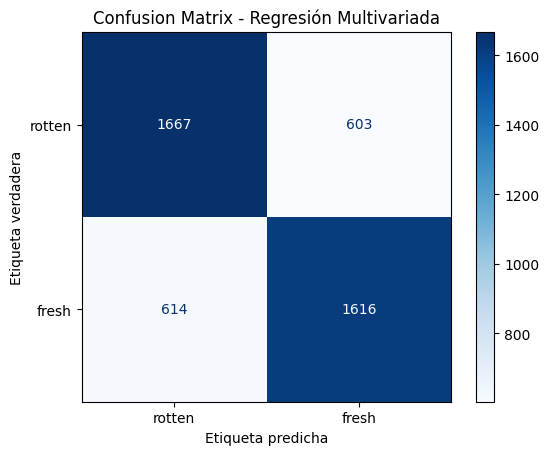

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

cm_reg_mult = [[1667, 603],
               [614, 1616]]

cm_reg_mult = np.array(cm_reg_mult)

labels = ['rotten', 'fresh']

disp = ConfusionMatrixDisplay(confusion_matrix=cm_reg_mult, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix - Regresión Multivariada')
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta verdadera')

plt.show()

Se obtuvo un rendimiento equilibrado en la clasificación de sentimientos en el conjunto de prueba, logrando un accuracy del 72.96%. El Classification Report muestra métricas de precisión, recall y f1-score consistentes y cercanas al 73% para ambas clases ('rotten' y 'fresh'), indicando que el modelo se desempeña de manera similar en la identificación de reseñas positivas y negativas. La matriz de confusión detalla que 1667 reseñas fueron correctamente identificadas como negativas (verdaderos negativos) y 1616 como positivas (verdaderos positivos). Asimismo, se registraron 603 falsos positivos (reseñas negativas predichas como positivas) y 614 falsos negativos (reseñas positivas predichas como negativas). La paridad en las métricas por clase y en la cantidad de errores de clasificación subraya que el modelo no presenta un sesgo significativo hacia ninguna categoría, ofreciendo un desempeño general sólido para la tarea de análisis de sentimiento que hemos venido trabajando.

### Modelo árbol de decisión

Para el mejor resultado del modelo de árbol de decisión, con los parámetros ajustados, tuvimos las siguientes métricas en la clasificación:



```
Accuracy (on Test Data):
63.47%

Classification Report (on Test Data):
              precision    recall  f1-score   support

           0       0.64      0.64      0.64      2270
           1       0.63      0.63      0.63      2230

    accuracy                           0.63      4500
   macro avg       0.63      0.63      0.63      4500
weighted avg       0.63      0.63      0.63      4500

```





```
Confusion Matrix (on Test Data):
[[1460  810]
 [ 834 1396]]
```



Graficando la la matriz de confusión tenemos lo siguiente:

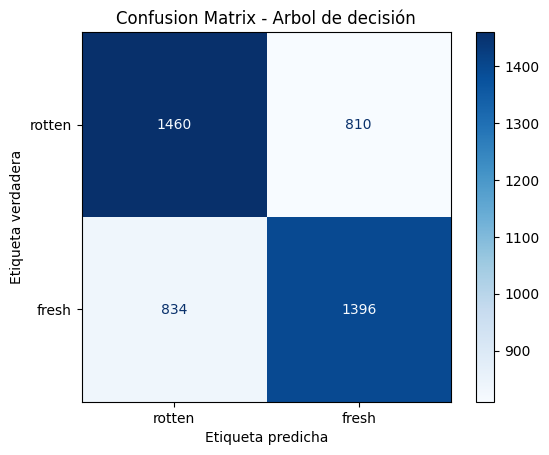

In [ ]:
cm_reg_mult = [[1460, 810],
               [834, 1396]]

cm_reg_mult = np.array(cm_reg_mult)

labels = ['rotten', 'fresh']

disp = ConfusionMatrixDisplay(confusion_matrix=cm_reg_mult, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix - Arbol de decisión')
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta verdadera')

plt.show()

Sé alcanzó un accuracy en el conjunto de prueba del 63.47%, un rendimiento notablemente inferior al de la Regresión Multivariada. El Classification Report revela métricas de precisión, recall y f1-score para ambas clases ('rotten' y 'fresh') consistentes y cercanas al 63%, lo que sugiere que, aunque se desempeña de manera similar en la clasificación de ambas categorías, su capacidad predictiva general es limitada. La matriz de confusión muestra que se identificaron correctamente 1460 reseñas negativas (verdaderos negativos) y 1396 positivas (verdaderos positivos). Sin embargo, el modelo cometió una cantidad significativa de errores, clasificando incorrectamente 810 reseñas negativas como positivas (falsos positivos) y 834 reseñas positivas como negativas (falsos negativos). La mayor proporción de errores de clasificación en comparación con las predicciones correctas indica que, a pesar de estar balanceado en su desempeño entre clases, el Árbol de Decisión no logra capturar las complejidades de los datos textuales de las reseñas con la misma efectividad que otros modelos, resultando en un rendimiento no tan favorable para la tarea de análisis de sentimiento.

### Modelo random forest

Para el mejor resultado del modelo de árbol de random forest, con los parámetros ajustados, tuvimos las siguientes métricas en la clasificación:



```
Accuracy (on Test Data):
70.96%

Classification Report (on Test Data):
              precision    recall  f1-score   support

           0       0.73      0.68      0.71      2304
           1       0.69      0.74      0.71      2196

    accuracy                           0.71      4500
   macro avg       0.71      0.71      0.71      4500
weighted avg       0.71      0.71      0.71      4500

```





```
Confusion Matrix (on Test Data):
[[1572  732]
 [ 575 1621]]
```



Graficando la confusión de matriz tenemos lo siguiente:

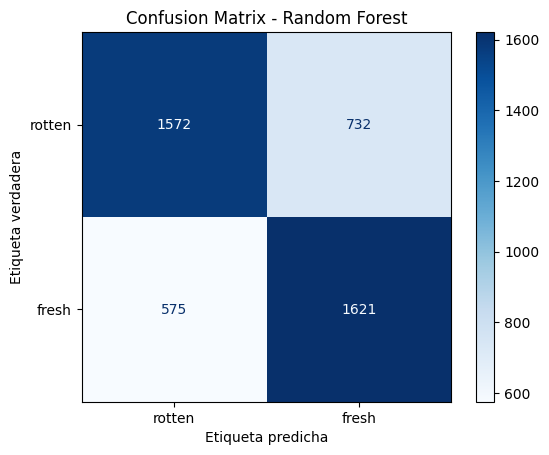

In [ ]:
cm_reg_mult = [[1572, 732],
               [575, 1621]]

cm_reg_mult = np.array(cm_reg_mult)

labels = ['rotten', 'fresh']

disp = ConfusionMatrixDisplay(confusion_matrix=cm_reg_mult, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta verdadera')

plt.show()

En este se obtuvo un accuracy en el conjunto de prueba del 70.96%. Al analizar el Classification Report, se observa un desempeño equilibrado entre las clases, con precision, recall y f1-score cercanos al 71%. Sin embargo, hay una ligera diferencia: la precisión para la clase ('rotten') es mayor (0.73) que para la clase ('fresh') (0.69), mientras que el recall es mayor para la clase 1 (0.74) que para la clase 0 (0.68). La matriz de confusión muestra 1572 verdaderos negativos y 1621 verdaderos positivos. Se identificaron 732 falsos positivos y 575 falsos negativos. Esta distribución de errores indica que el modelo es ligeramente más propenso a clasificar incorrectamente reseñas negativas como positivas (más falsos positivos) que reseñas positivas como negativas (menos falsos negativos), aunque en general ofrece un rendimiento competitivo y superior al árbol de Decisión para la tarea de análisis de sentimiento.

### Modelo redes neuronales perceptrón multicapas

Para el mejor resultado del modelo de redes neuronales perceptrón multicapas, con los parámetros ajustados, tuvimos las siguientes métricas en la clasificación:



```
Accuracy (on Test Data):
70.53%

Classification Report (on Test Data):
              precision    recall  f1-score   support

           0       0.72      0.68      0.70      2275
           1       0.69      0.73      0.71      2225

    accuracy                           0.71      4500
   macro avg       0.71      0.71      0.71      4500
weighted avg       0.71      0.71      0.71      4500

```





```
Confusion Matrix (on Test Data):
[[1555  720]
 [ 606 1619]]
```



Graficando la confusión de matriz tenemos lo siguiente:

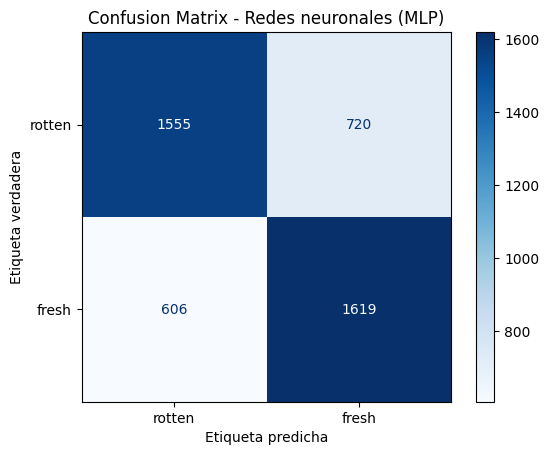

In [ ]:
cm_reg_mult = [[1555, 720],
               [606, 1619]]

cm_reg_mult = np.array(cm_reg_mult)

labels = ['rotten', 'fresh']

disp = ConfusionMatrixDisplay(confusion_matrix=cm_reg_mult, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix - Redes neuronales (MLP)')
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta verdadera')

plt.show()

Se alcanzó un accuracy en el conjunto de prueba del 70.53%. Este rendimiento es comparable al obtenido con la Regresión Multivariada y Random Forest. El análisis del Classification Report revela un desempeño equilibrado entre las clases 'rotten' y 'fresh', con métricas de precisión, recall y f1-score que rondan el 71%, aunque con una ligera mayor precisión para la clase 0 y mayor recall para la clase 1. La matriz de confusión confirma este equilibrio, mostrando 1555 verdaderos negativos y 1619 verdaderos positivos, junto con 720 falsos positivos y 606 falsos negativos. A pesar de los errores de clasificación, la distribución de aciertos y errores indica que el modelo MLP, con el preprocesamiento y las arquitecturas exploradas, ofrece un rendimiento competitivo con respecto a los otros modelos.

### Modelo redes neuronales profundas

Para el mejor resultado del modelo de redes neuronales profundo, con los parámetros ajustados, tuvimos las siguientes métricas en la clasificación:



```
Accuracy (on Test Data):
71.00%


Classification Report (on Test Data):
              precision    recall  f1-score   support

           0       0.71      0.71      0.71      2266
           1       0.71      0.71      0.71      2234

    accuracy                           0.71      4500
   macro avg       0.71      0.71      0.71      4500
weighted avg       0.71      0.71      0.71      4500

```





```
Confusion Matrix (on Test Data):
[[1615  651]
 [ 654 1580]]
```





Graficando la confusión de matriz tenemos lo siguiente:

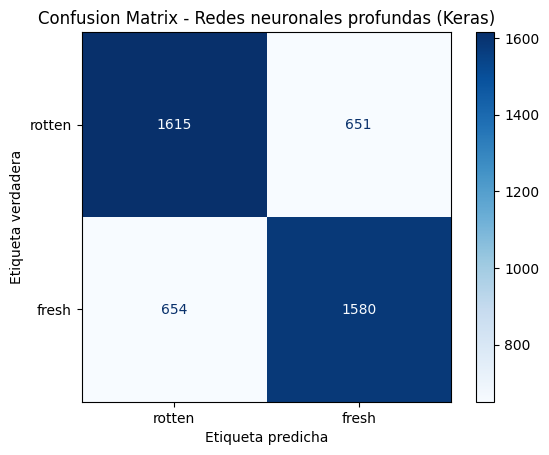

In [ ]:
cm_reg_mult = [[1615, 651],
               [654, 1580]]

cm_reg_mult = np.array(cm_reg_mult)

labels = ['rotten', 'fresh']

disp = ConfusionMatrixDisplay(confusion_matrix=cm_reg_mult, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix - Redes neuronales profundas (Keras)')
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta verdadera')

plt.show()

Para este modelo se logró un accuracy en el conjunto de prueba del 71.00%. Este rendimiento es comparable al obtenido con otros modelos explorados, como la Regresión Logística y Random Forest, que también se situaron en el rango del 70-72% con este preprocesamiento. El análisis del Classification Report muestra un desempeño equilibrado entre las clases 'rotten' y 'fresh', con métricas de precisión, recall y f1-score que rondan el 71% para ambas categorías, reflejando la distribución balanceada del dataset. La matriz de confusión confirma este equilibrio, mostrando 1615 predicciones correctas para la clase 0 (verdaderos negativos) y 1580 para la clase 1 (verdaderos positivos). Los errores se distribuyen en 651 falsos positivos y 654 falsos negativos, indicando que el modelo tiene una dificultad similar para distinguir ambas clases cuando comete un error. A pesar del sobreajuste observado durante el entrenamiento, el rendimiento final en prueba de la DNN es competitivo, demostrando ser una opción viable para la tarea de análisis de sentimientos con las características TF-IDF, aunque sin superar significativamente el rendimiento de otros modelos más simples.

En el análisis comparativo de los modelos aplicados a la tarea de clasificación de sentimientos, la Regresión Multivariable destacó como el modelo con mejor desempeño, alcanzando un accuracy del 72.96% y métricas equilibradas entre clases, lo que indica una generalización efectiva. Le siguen de cerca Random Forest (70.96%) y las Redes Neuronales Profundas con Keras (71.00%), ambos con resultados consistentes y sin sesgos importantes, aunque sin superar al modelo de regresión. El modelo MLP obtuvo un rendimiento ligeramente inferior (70.53%), mientras que el Árbol de Decisión mostró el desempeño más bajo (63.47%), evidenciando mayores dificultades para capturar patrones complejos en los datos textuales. En conjunto, los resultados sugieren que modelos más sofisticados como Random Forest y redes neuronales ofrecen mejoras con respecto a métodos más simples, pero en este caso, la Regresión Multivariable logró el mejor equilibrio entre precisión y simplicidad.



Ahora bien, procedemos a la sección de las conclusiones finales del proyecto.

## 6. Conclusiones de los resultados obtenidos

El presente proyecto tuvo como objetivo desarrollar un modelo de clasificación capaz de predecir si una reseña de película es positiva ("fresh") o negativa ("rotten"), utilizando el conjunto de datos de Rotten Tomatoes. A lo largo del trabajo, se aplicaron técnicas de preprocesamiento textual como la conversión a minúsculas, eliminación de stopwords, símbolos y puntuación, así como lematización con POS tagging para normalizar el lenguaje natural, vectorización de texto (TF-IDF) y tambien seleccion de características con Random Forest, y con ello, se entrenaron y evaluaron modelos de clasificación logrando métricas de desempeño razonables en términos de precisión, recall y accuracy. Sin embargo, los resultados muestran un margen de mejora importante, en especial en cuanto a la capacidad de generalización en datos no vistos.

Por otro lado, para mejorar el trabajo realizado se propone el siguiente esquema:

* El uso de embeddings preentrenados, aunque TF-IDF es una técnica sólida, no captura el significado contextual de las palabras. Se podría usar representaciones semánticas más ricas como Word2Vec, GloVe o FastText, o embeddings contextuales como BERT, que entienden la posición y contexto de las palabras en la oración.

* Se podría implementar modelos de Deep Learning especializados en texto como LSTM, GRU o transformers, puesto que permitiría modelar dependencias secuenciales y mejorar la comprensión del texto. Esto suele mejorar la generalización, especialmente cuando se trabaja con lenguaje natural.

* El uso del dataset completo, trabajamos con una muestra representativa (15.000), pero escalar a todo el conjunto podría permitir que modelos más complejos como redes profundas o transformers aprovechen más información y generalicen mejor, asi que se sugiere tambien el uso de equipos muy buenos computacionalmente para un trabajo más exhaustivo y resultados más prometedores.









## 7. Referencias

[1] Pedersen, U. T. (2023, marzo 1). Rotten Tomatoes Reviews. Kaggle. https://www.kaggle.com/datasets/ulrikthygepedersen/rotten-tomatoes-reviews/data



[2] Hariharan, A. (2023, abril 30). RT Reviews Classification with LSTM. Kaggle. https://www.kaggle.com/code/hariharanalm/rt-reviews-classification-with-lstm/notebook



[3] scikit-learn developers. Supervised learning. scikit-learn. https://scikit-learn.org/stable/supervised_learning.html



[4] Built In. (2024, febrero 8). What is TF-IDF? https://builtin.com/articles/tf-idf